In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
#import folium
from datetime import datetime,date
from scipy.interpolate import make_interp_spline, BSpline
from lmfit import Minimizer, Parameters, report_fit
import chart_studio.plotly as py

%matplotlib inline
from lmfit import Minimizer, Parameters, report_fit
import os

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf

In [2]:
def Reverse(lst): 
    return [ele for ele in reversed(lst)]

In [3]:
path='data/COVID19/JHU/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series'
confirmed_fn=os.path.join(path,'time_series_covid19_confirmed_global.csv')
deaths_fn=os.path.join(path,'time_series_covid19_deaths_global.csv')
recovered_fn=os.path.join(path,'time_series_covid19_recovered_global.csv')

In [4]:
df_confirmed = pd.read_csv(confirmed_fn)
df_deaths = pd.read_csv(deaths_fn)
df_recovered = pd.read_csv(recovered_fn)

In [5]:
worldTotalConfirmed= df_confirmed.drop(['Lat','Long','Province/State','Country/Region'],axis =1).sum()
worldTot=pd.DataFrame(worldTotalConfirmed,columns=['cases'])
worldTot.head()
worldTot.to_csv('worldTot.csv')

In [6]:
Rows2,Cols2=df_confirmed.shape
cols2=df_confirmed.columns
#cols1

# @interact
# def show_df_confirmed(columns=cols2,x=(1,Rows2,1)):
#     return df_active.iloc[x:x+5]

In [7]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [8]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"

df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])

In [9]:
df_active = df_confirmed.copy()
df_active.iloc[:,5:] = df_active.iloc[:,5:] - df_recovered.iloc[:,5:] - df_deaths.iloc[:,5:]


In [10]:
Rows,Cols=df_active.shape
cols1=df_active.columns
#cols1

@interact
def show_df_active(columns=cols1,x=(1,Rows,1)):
    return df_active.iloc[x:x+5]

interactive(children=(Dropdown(description='columns', options=('state', 'country', 'Lat', 'Long', '1/22/20', '…

In [11]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
df_recovered = df_recovered.replace(np.nan, '', regex=True)
df_active = df_active.replace(np.nan, '', regex=True)

In [12]:
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days

In [13]:
confirmed_cases =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
recovered_cases = df_recovered.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
deaths = df_deaths.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]
active_cases = df_active.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).iloc[:,-1]

confirmed_cases.name = "Confirmed Cases"
recovered_cases.name = "Recovered Cases"
deaths.name = "Deaths Reported"
active_cases.name = "Active Cases"
df_countries_cases = pd.DataFrame([confirmed_cases,recovered_cases,deaths,active_cases]).transpose()

In [14]:
LL,tt=df_countries_cases.shape
cols=df_countries_cases.columns
cols

Index(['Confirmed Cases', 'Recovered Cases', 'Deaths Reported',
       'Active Cases'],
      dtype='object')

In [15]:
@interact
def show_df_countries_cases(column=cols, x=(1,LL,1)):
    return df_countries_cases.iloc[x:x+5]

interactive(children=(Dropdown(description='column', options=('Confirmed Cases', 'Recovered Cases', 'Deaths Re…

In [16]:
Top10_Deaths=list(df_countries_cases.sort_values('Deaths Reported')["Deaths Reported"].index[-10:])
Top10_Confirmed=list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-10:])
Top10_Recovered=list(df_countries_cases.sort_values('Recovered Cases')["Recovered Cases"].index[-10:])
Top10_Active=list(df_countries_cases.sort_values('Active Cases')["Active Cases"].index[-10:])

In [17]:
Top10_Confirmed=Reverse(list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-10:]))

In [18]:
confirmed_series =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Confirmed].T
recovered_series = df_recovered.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Confirmed].T
deaths_series = df_deaths.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Recovered].T
active_series = df_active.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top10_Active].T

In [19]:

Top21_Confirmed=Reverse(list(df_countries_cases.sort_values('Confirmed Cases')["Confirmed Cases"].index[-51:]))


In [20]:
confirmed_series_21 =  df_confirmed.groupby(["country"]).sum().drop(['Lat','Long'],axis =1).loc[Top21_Confirmed].T


In [21]:
def Cauchy_cumulative_hazard(x,loc,scale,decaybase):
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    return -np.log(0.5 - np.arctan(z)/np.pi)

# define objective function: returns the array to be minimized
def Cauchy_cumulative_hazard_residual(params, x, data):
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    loc = params['loc']
    scale = params['scale']
    decaybase=params['decaybase']
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
#     decayterm=1.0
    model = amp * (-np.log(0.5 - np.arctan((x-loc)/(scale*decayterm))/np.pi))
    return model - data

In [22]:
print(Top21_Confirmed)

['USA', 'Spain', 'Italy', 'United Kingdom', 'Russia', 'France', 'Germany', 'Brazil', 'Turkey', 'Iran', 'China', 'Canada', 'Peru', 'India', 'Belgium', 'Netherlands', 'Saudi Arabia', 'Ecuador', 'Switzerland', 'Mexico', 'Portugal', 'Pakistan', 'Sweden', 'Chile', 'Ireland', 'Singapore', 'Belarus', 'Qatar', 'Israel', 'United Arab Emirates', 'Austria', 'Japan', 'Poland', 'Romania', 'Ukraine', 'Indonesia', 'Bangladesh', 'South Korea', 'Philippines', 'Denmark', 'Serbia', 'Colombia', 'Dominican Republic', 'South Africa', 'Norway', 'Czechia', 'Egypt', 'Panama', 'Australia', 'Kuwait', 'Malaysia']


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1235
    # data points      = 98
    # variables        = 4
    chi-square         = 0.02473069
    reduced chi-square = 2.6309e-04
    Akaike info crit   = -803.898407
    Bayesian info crit = -793.558537
[[Variables]]
    amp:        0.23601152 +/- 0.00645173 (2.73%) (init = 1)
    scale:      1.96837464 +/- 0.14469755 (7.35%) (init = 1)
    loc:        28.2552590 +/- 0.10598618 (0.38%) (init = 70)
    decaybase:  1.00500000 +/- 0.00106335 (0.11%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.954
    C(amp, decaybase)   = -0.864
    C(scale, decaybase) = -0.690
    C(loc, decaybase)   = -0.348
    C(amp, loc)         =  0.141


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



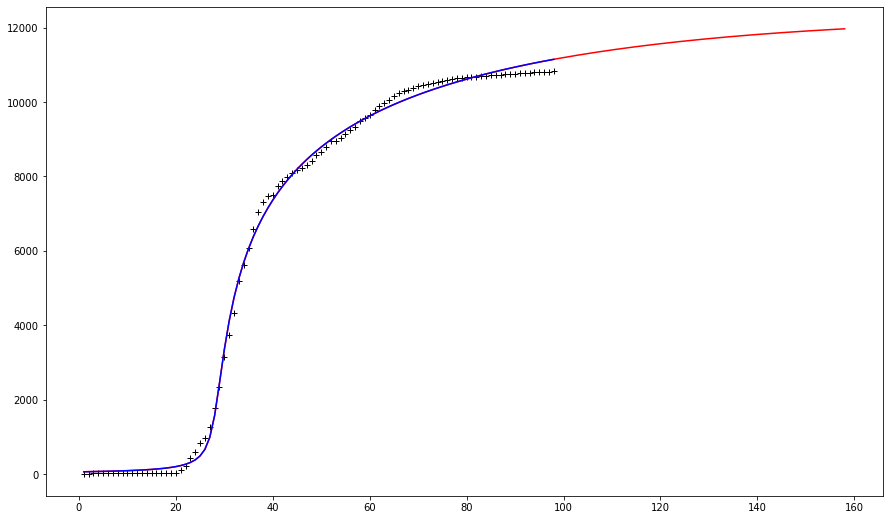

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [23]:
import chart_studio.plotly as py
# basic data
theCountry='South Korea'
threshhold=6
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1,min=0.95,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title='Projected COVID-19 Cases in South Kerea')

@interact
def plot_ProjectedSouthKereaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title='Projected COVID-19 Cases in South Korea',
                 theme='solar',
                 filename='COVID19-South-Korea',
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename='COVID19-South-Korea')
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 95
    # variables        = 4
    chi-square         = 0.01294253
    reduced chi-square = 1.4223e-04
    Akaike info crit   = -837.605766
    Bayesian info crit = -827.390258
[[Variables]]
    amp:        0.10549372 +/- 9.6298e-04 (0.91%) (init = 1)
    scale:      7.32217627 +/- 0.57660619 (7.87%) (init = 1)
    loc:        54.9866632 +/- 0.24644239 (0.45%) (init = 70)
    decaybase:  0.85000000 +/- 0.00601436 (0.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale, loc)       = -0.785
    C(amp, scale)       =  0.513
    C(amp, decaybase)   =  0.492
    C(scale, decaybase) = -0.165
    C(loc, decaybase)   =  0.119


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



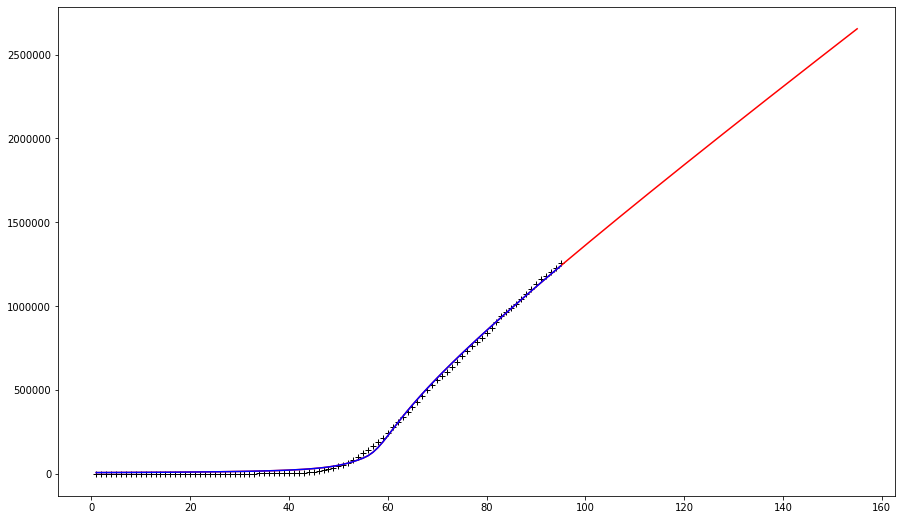

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [24]:
# basic data
theCountry='USA'
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.05)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title='Projected COVID-19 Cases in USA')

@interact
def plot_ProjectedUSACOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title='Projected COVID-19 Cases in USA',
                 theme='solar',
                 filename='COVID19-USA',
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename='COVID19-USA')
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 221
    # data points      = 73
    # variables        = 4
    chi-square         = 0.03710756
    reduced chi-square = 5.3779e-04
    Akaike info crit   = -545.660761
    Bayesian info crit = -536.498923
[[Variables]]
    amp:        0.11151636 +/- 0.02405070 (21.57%) (init = 1)
    scale:      10.6229809 +/- 2.68199139 (25.25%) (init = 1)
    loc:        34.5686683 +/- 1.41585370 (4.10%) (init = 70)
    decaybase:  0.85000000 +/- 0.04178501 (4.92%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.936
    C(amp, loc)         =  0.933
    C(scale, loc)       = -0.927
    C(scale, decaybase) = -0.827
    C(amp, scale)       = -0.800


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



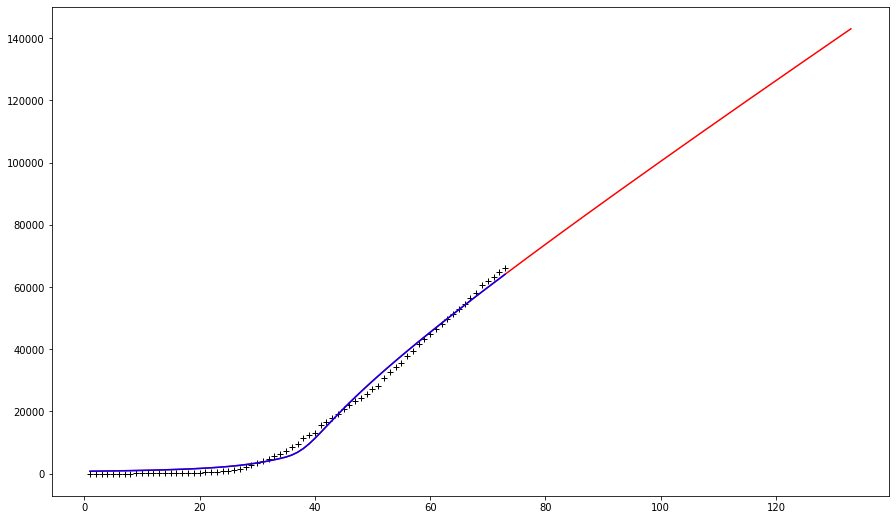

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [25]:
# basic data
theCountry='Canada'
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.05)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title='Projected COVID-19 Cases in Canada')

@interact
def plot_ProjectedCanadaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title='Projected COVID-19 Cases in Canada',
                 theme='solar',
                 filename='COVID19-Canada',
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename='COVID19-Canada')
    print(url)

In [26]:
print(Top21_Confirmed)

['USA', 'Spain', 'Italy', 'United Kingdom', 'Russia', 'France', 'Germany', 'Brazil', 'Turkey', 'Iran', 'China', 'Canada', 'Peru', 'India', 'Belgium', 'Netherlands', 'Saudi Arabia', 'Ecuador', 'Switzerland', 'Mexico', 'Portugal', 'Pakistan', 'Sweden', 'Chile', 'Ireland', 'Singapore', 'Belarus', 'Qatar', 'Israel', 'United Arab Emirates', 'Austria', 'Japan', 'Poland', 'Romania', 'Ukraine', 'Indonesia', 'Bangladesh', 'South Korea', 'Philippines', 'Denmark', 'Serbia', 'Colombia', 'Dominican Republic', 'South Africa', 'Norway', 'Czechia', 'Egypt', 'Panama', 'Australia', 'Kuwait', 'Malaysia']


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 160
    # data points      = 63
    # variables        = 4
    chi-square         = 0.01933730
    reduced chi-square = 3.2775e-04
    Akaike info crit   = -501.597819
    Bayesian info crit = -493.025280
[[Variables]]
    amp:        0.21744495 +/- 0.01556433 (7.16%) (init = 1)
    scale:      5.23047578 +/- 0.34410709 (6.58%) (init = 1)
    loc:        22.3586884 +/- 0.46122884 (2.06%) (init = 70)
    decaybase:  0.96374317 +/- 0.00689883 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.980
    C(loc, decaybase)   =  0.902
    C(amp, loc)         =  0.880
    C(amp, scale)       =  0.686
    C(scale, decaybase) =  0.544
    C(scale, loc)       =  0.355


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



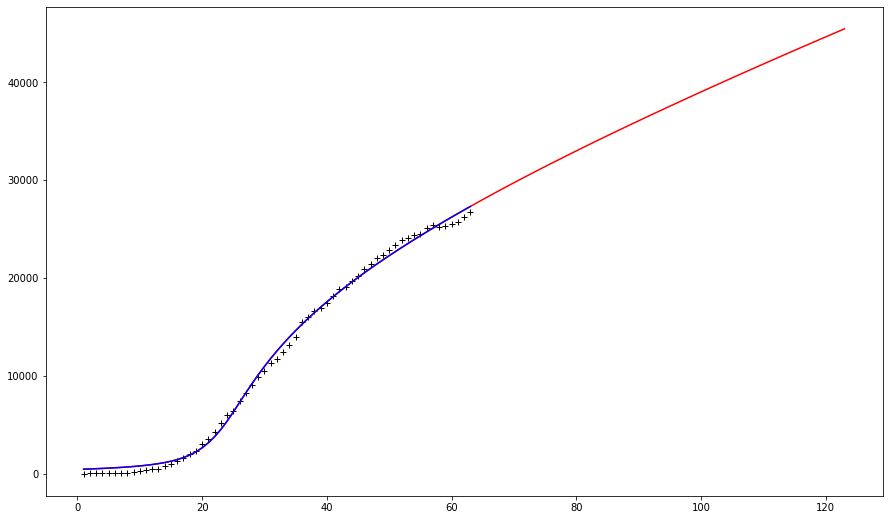

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [27]:
theCountry='Portugal'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.025)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedPortugalCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 99
    # variables        = 4
    chi-square         = 0.02079053
    reduced chi-square = 2.1885e-04
    Akaike info crit   = -830.369361
    Bayesian info crit = -819.988882
[[Variables]]
    amp:        0.46135451 +/- 0.01753719 (3.80%) (init = 1)
    scale:      7.89927106 +/- 0.19491735 (2.47%) (init = 1)
    loc:        71.0599396 +/- 0.41965944 (0.59%) (init = 70)
    decaybase:  1.00924511 +/- 0.00296242 (0.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.961
    C(amp, decaybase)   =  0.931
    C(loc, decaybase)   =  0.909
    C(amp, scale)       =  0.472
    C(scale, loc)       =  0.360
    C(scale, decaybase) =  0.151


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



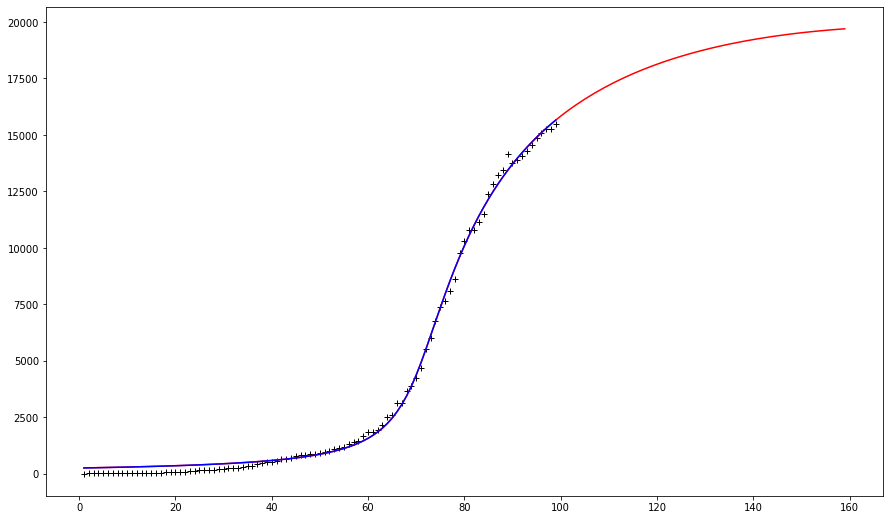

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [28]:
theCountry='Japan'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.025)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedJapanCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 554
    # data points      = 97
    # variables        = 4
    chi-square         = 0.07184728
    reduced chi-square = 7.7255e-04
    Akaike info crit   = -691.168581
    Bayesian info crit = -680.869737
[[Variables]]
    amp:        0.27280744 +/- 0.01491534 (5.47%) (init = 1)
    scale:      2.43577077 +/- 0.27490186 (11.29%) (init = 1)
    loc:        51.1891799 +/- 0.21472188 (0.42%) (init = 70)
    decaybase:  1.00500000 +/- 0.00973415 (0.97%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.920
    C(amp, decaybase)   = -0.884
    C(scale, decaybase) = -0.646
    C(loc, decaybase)   = -0.639
    C(amp, loc)         =  0.510
    C(scale, loc)       =  0.263


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



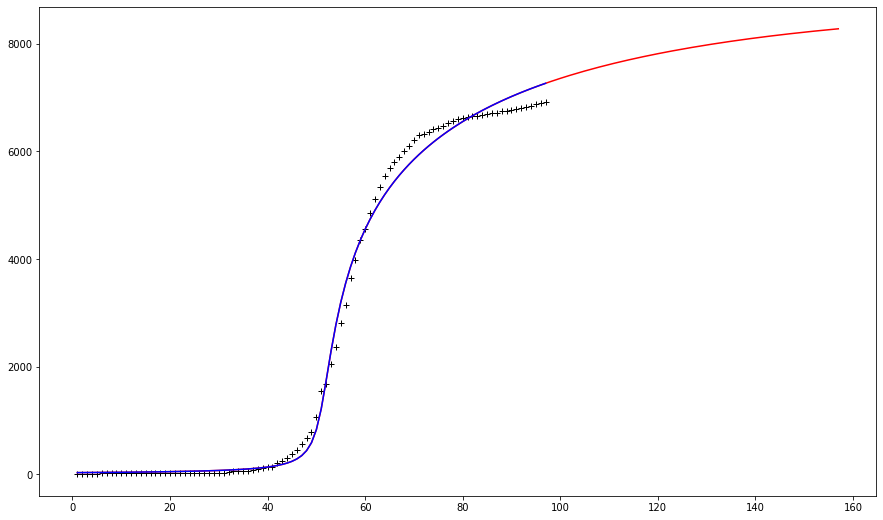

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [29]:
theCountry='Australia'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

mmx=np.max(y1*last)
yy1=y1*last
dyy1=output['Increase']
yy1[dyy1<0]=mmx
dyy1[dyy1<0]=0
output['Forecast']=yy1
output['Increase']=dyy1


@interact
def plot_ProjectedAustraliaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1536
    # data points      = 107
    # variables        = 4
    chi-square         = 0.40725606
    reduced chi-square = 0.00395394
    Akaike info crit   = -588.112193
    Bayesian info crit = -577.420877
[[Variables]]
    amp:        0.20810674 +/- 0.01953067 (9.38%) (init = 1)
    scale:      1.14149625 +/- 0.37507388 (32.86%) (init = 1)
    loc:        12.6236775 +/- 0.33244968 (2.63%) (init = 70)
    decaybase:  1.00500000 +/- 0.00265988 (0.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.974
    C(amp, decaybase)   = -0.846
    C(scale, decaybase) = -0.716
    C(scale, loc)       = -0.347
    C(amp, loc)         = -0.243


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



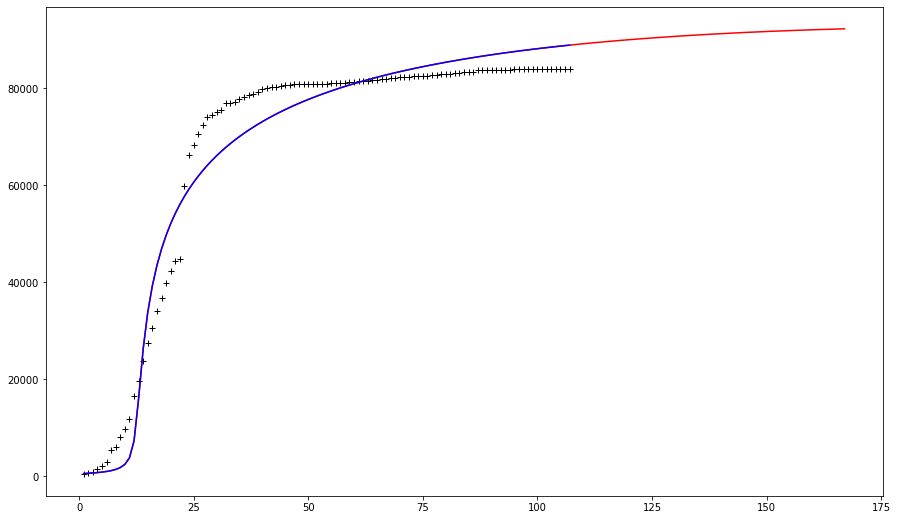

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [30]:
theCountry='China'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.95,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

mmx=np.max(y1*last)
yy1=y1*last
dyy1=output['Increase']
yy1[dyy1<0]=mmx
dyy1[dyy1<0]=0
output['Forecast']=yy1
output['Increase']=dyy1
output['Fitting'].iloc[:dataLen]=output['Forecast'].iloc[:dataLen]

@interact
def plot_ProjectedChinaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 512
    # data points      = 69
    # variables        = 4
    chi-square         = 0.02597601
    reduced chi-square = 3.9963e-04
    Akaike info crit   = -536.043505
    Bayesian info crit = -527.107079
[[Variables]]
    amp:        0.34632974 +/- 0.01550124 (4.48%) (init = 1)
    scale:      6.46264852 +/- 0.34081723 (5.27%) (init = 1)
    loc:        21.3441129 +/- 0.40067681 (1.88%) (init = 70)
    decaybase:  1.00500000 +/- 0.00300743 (0.30%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.921
    C(loc, decaybase)   = -0.890
    C(amp, loc)         =  0.886
    C(amp, scale)       =  0.836
    C(scale, loc)       =  0.591
    C(scale, decaybase) = -0.574


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



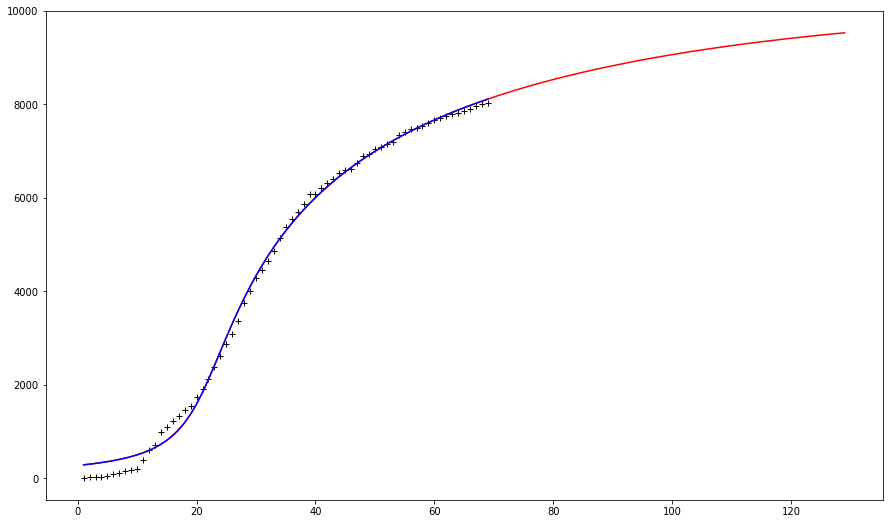

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [31]:
theCountry='Norway'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedNorwayCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 63
    # variables        = 4
    chi-square         = 0.04541405
    reduced chi-square = 7.6973e-04
    Akaike info crit   = -447.809316
    Bayesian info crit = -439.236777
[[Variables]]
    amp:        0.27016043 +/- 0.12487995 (46.22%) (init = 1)
    scale:      7.94949863 +/- 2.27899495 (28.67%) (init = 1)
    loc:        44.5493645 +/- 3.39378543 (7.62%) (init = 70)
    decaybase:  0.92581424 +/- 0.07206374 (7.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.996
    C(loc, decaybase)   =  0.993
    C(scale, decaybase) = -0.970
    C(scale, loc)       = -0.965
    C(amp, scale)       = -0.956


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



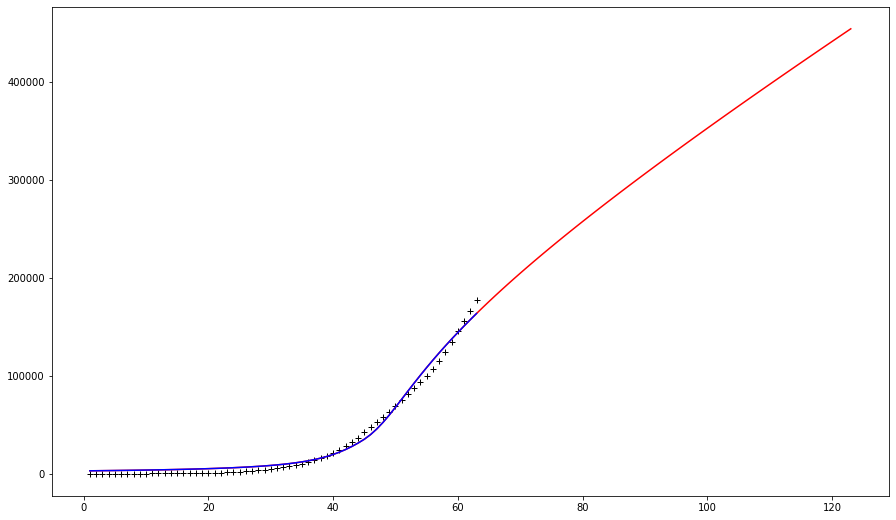

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [32]:
theCountry='Russia'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedRussiaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 144
    # data points      = 69
    # variables        = 4
    chi-square         = 0.02641536
    reduced chi-square = 4.0639e-04
    Akaike info crit   = -534.886220
    Bayesian info crit = -525.949794
[[Variables]]
    amp:        0.17457088 +/- 0.03288174 (18.84%) (init = 1)
    scale:      12.7804610 +/- 2.15443634 (16.86%) (init = 1)
    loc:        29.0981067 +/- 1.86035625 (6.39%) (init = 70)
    decaybase:  0.92133125 +/- 0.02372423 (2.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(loc, decaybase)   =  0.979
    C(amp, loc)         =  0.979
    C(scale, loc)       = -0.940
    C(scale, decaybase) = -0.912
    C(amp, scale)       = -0.888


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



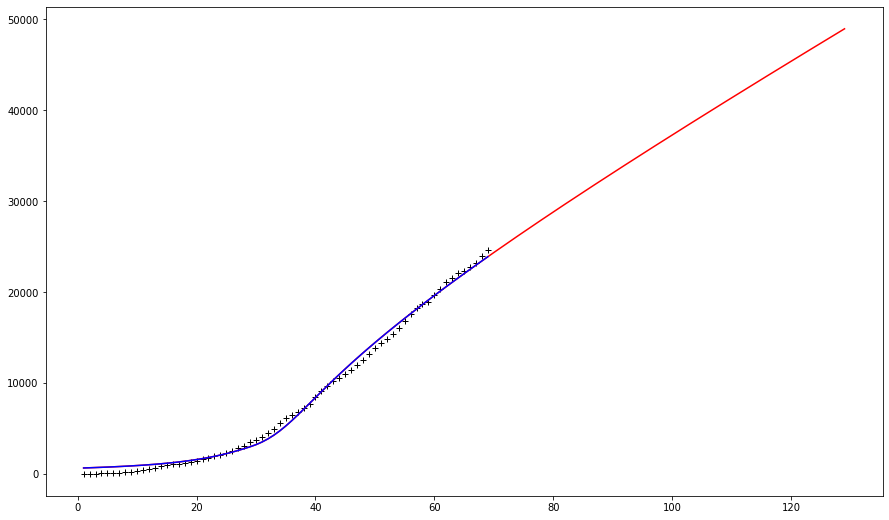

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [33]:
theCountry='Sweden'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedSwedenCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 395
    # data points      = 66
    # variables        = 4
    chi-square         = 0.02167611
    reduced chi-square = 3.4961e-04
    Akaike info crit   = -521.399151
    Bayesian info crit = -512.640532
[[Variables]]
    amp:        0.25377790 +/- 0.01380462 (5.44%) (init = 1)
    scale:      4.30867845 +/- 0.29048836 (6.74%) (init = 1)
    loc:        25.2961809 +/- 0.31753401 (1.26%) (init = 70)
    decaybase:  0.98233640 +/- 0.00437265 (0.45%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.958
    C(loc, decaybase)   =  0.858
    C(amp, loc)         =  0.820
    C(amp, scale)       =  0.810
    C(scale, decaybase) =  0.626
    C(scale, loc)       =  0.438


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



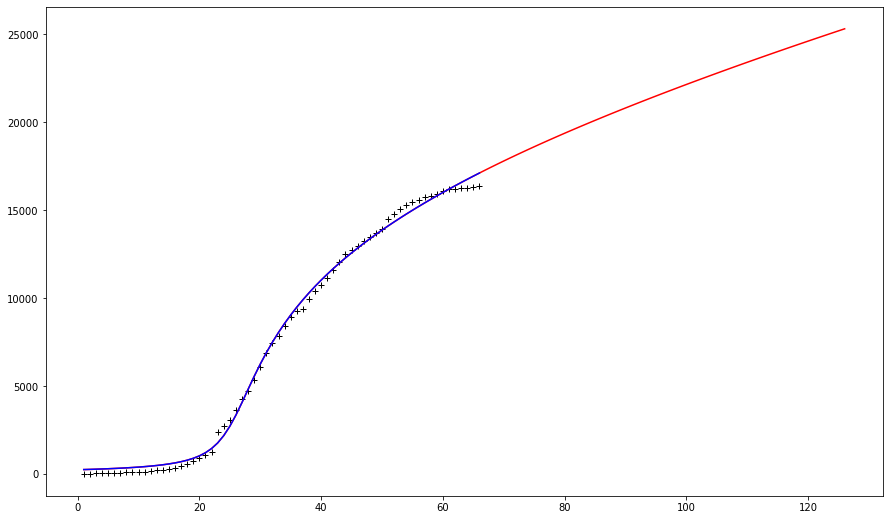

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [34]:
theCountry='Israel'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedIsraelCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1048
    # data points      = 68
    # variables        = 4
    chi-square         = 0.02935426
    reduced chi-square = 4.5866e-04
    Akaike info crit   = -518.852131
    Bayesian info crit = -509.974100
[[Variables]]
    amp:        0.28769854 +/- 0.01244731 (4.33%) (init = 1)
    scale:      3.15122636 +/- 0.24897245 (7.90%) (init = 1)
    loc:        21.6104004 +/- 0.20528636 (0.95%) (init = 70)
    decaybase:  1.00500000 +/- 9.5903e-04 (0.10%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, scale)       =  0.906
    C(amp, decaybase)   = -0.893
    C(loc, decaybase)   = -0.733
    C(amp, loc)         =  0.641
    C(scale, decaybase) = -0.635
    C(scale, loc)       =  0.380


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



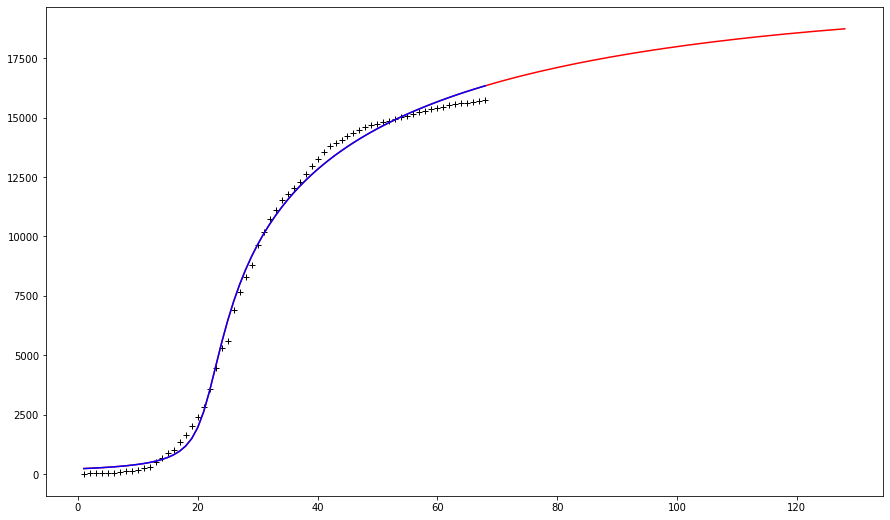

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [35]:
theCountry='Austria'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedAustriaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 154
    # data points      = 63
    # variables        = 4
    chi-square         = 0.04918419
    reduced chi-square = 8.3363e-04
    Akaike info crit   = -442.785018
    Bayesian info crit = -434.212480
[[Variables]]
    amp:        0.35037024 +/- 0.12327665 (35.18%) (init = 1)
    scale:      10.9596287 +/- 2.28479695 (20.85%) (init = 1)
    loc:        44.6230840 +/- 3.60766754 (8.08%) (init = 70)
    decaybase:  0.94842926 +/- 0.03985338 (4.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.997
    C(amp, decaybase)   =  0.993
    C(loc, decaybase)   =  0.987
    C(scale, decaybase) = -0.971
    C(scale, loc)       = -0.955
    C(amp, scale)       = -0.950


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



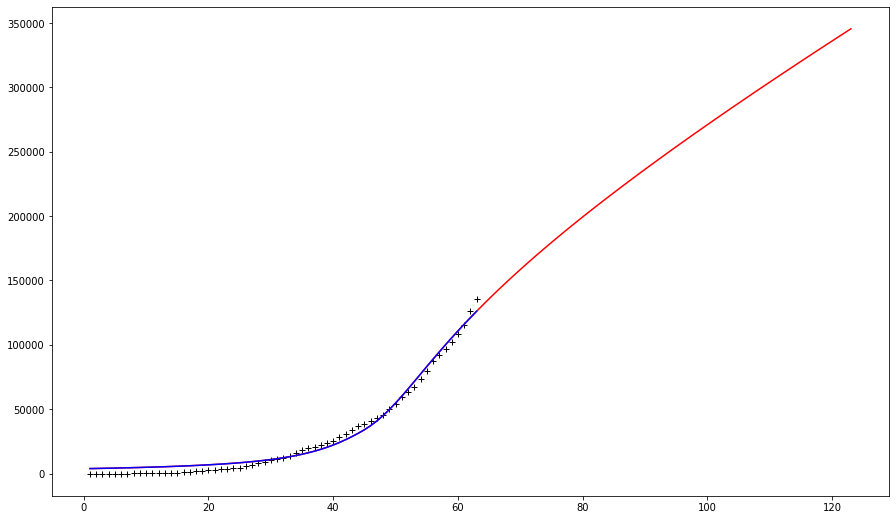

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [36]:
theCountry='Brazil'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedBrazilCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 320
    # data points      = 67
    # variables        = 4
    chi-square         = 0.02788103
    reduced chi-square = 4.4256e-04
    Akaike info crit   = -513.561603
    Bayesian info crit = -504.742833
[[Variables]]
    amp:        0.22870061 +/- 0.02204099 (9.64%) (init = 1)
    scale:      6.85713472 +/- 0.42169694 (6.15%) (init = 1)
    loc:        25.0443844 +/- 0.76824585 (3.07%) (init = 70)
    decaybase:  0.96278407 +/- 0.00900305 (0.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.944
    C(amp, loc)         =  0.934
    C(amp, scale)       =  0.483
    C(scale, decaybase) =  0.353
    C(scale, loc)       =  0.228


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



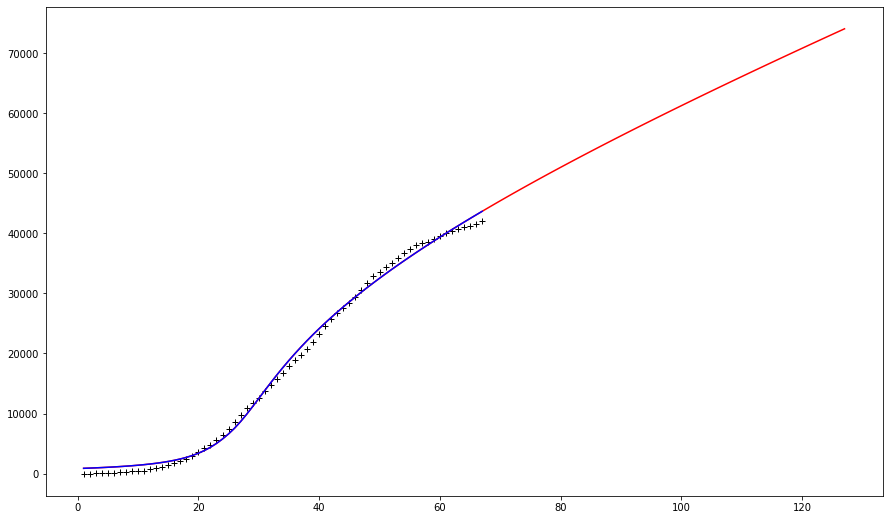

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [37]:
theCountry='Netherlands'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedNetherlandsCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 287
    # data points      = 66
    # variables        = 4
    chi-square         = 0.02526300
    reduced chi-square = 4.0747e-04
    Akaike info crit   = -511.292570
    Bayesian info crit = -502.533951
[[Variables]]
    amp:        0.22056726 +/- 0.02097042 (9.51%) (init = 1)
    scale:      6.36070526 +/- 0.39391890 (6.19%) (init = 1)
    loc:        26.1252947 +/- 0.70093513 (2.68%) (init = 70)
    decaybase:  0.95722502 +/- 0.00969846 (1.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.939
    C(amp, loc)         =  0.929
    C(amp, scale)       =  0.461
    C(scale, decaybase) =  0.333
    C(scale, loc)       =  0.190


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



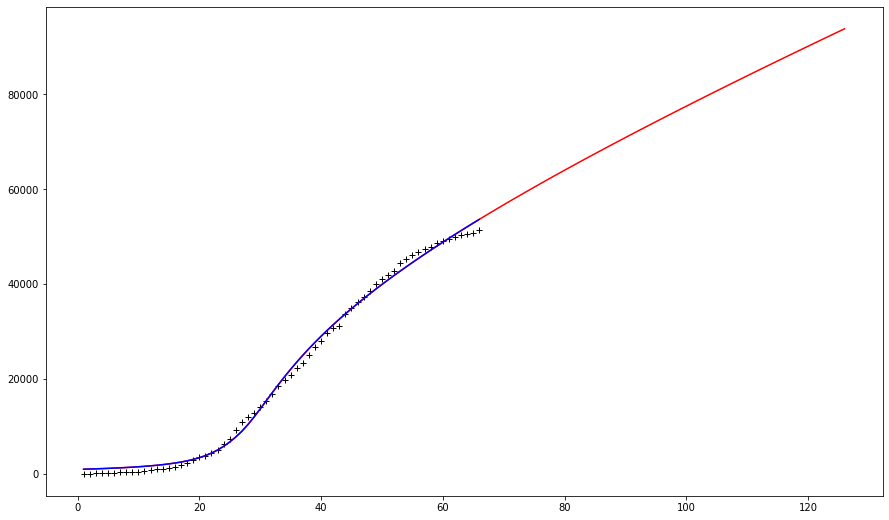

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [38]:
theCountry='Belgium'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedBelgiumCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 508
    # data points      = 69
    # variables        = 4
    chi-square         = 0.02607402
    reduced chi-square = 4.0114e-04
    Akaike info crit   = -535.783646
    Bayesian info crit = -526.847220
[[Variables]]
    amp:        0.32342024 +/- 0.01373602 (4.25%) (init = 1)
    scale:      4.78170468 +/- 0.28466019 (5.95%) (init = 1)
    loc:        23.0797177 +/- 0.29031670 (1.26%) (init = 70)
    decaybase:  1.00500000 +/- 0.00133203 (0.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.910
    C(amp, scale)       =  0.862
    C(loc, decaybase)   =  0.848
    C(amp, loc)         =  0.816
    C(scale, decaybase) =  0.592
    C(scale, loc)       =  0.525


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



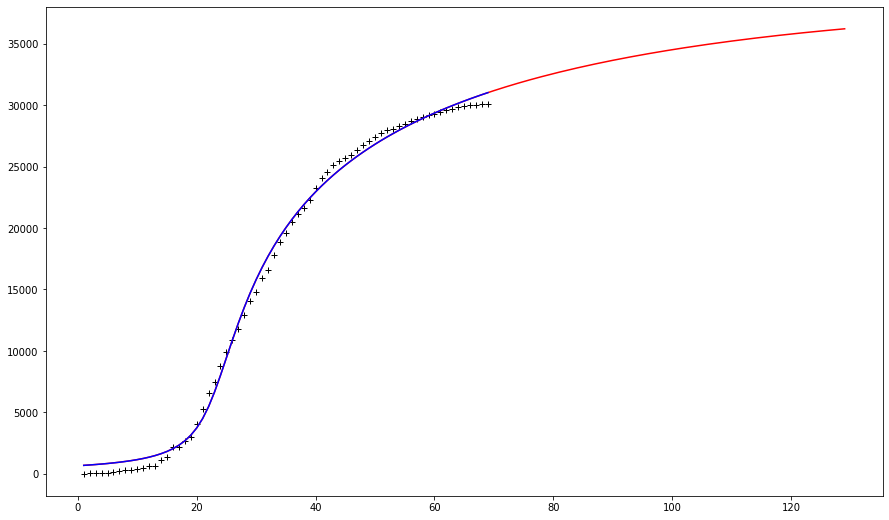

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [39]:
theCountry='Switzerland'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedSwitzerlandCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6227
    # data points      = 74
    # variables        = 4
    chi-square         = 0.01318253
    reduced chi-square = 1.8832e-04
    Akaike info crit   = -630.836679
    Bayesian info crit = -621.620418
[[Variables]]
    amp:        0.10919422 +/- 0.01339593 (12.27%) (init = 1)
    scale:      8.79055539 +/- 1.11183335 (12.65%) (init = 1)
    loc:        35.2395457 +/- 0.75454065 (2.14%) (init = 70)
    decaybase:  0.85000000 +/- 0.00242785 (0.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.925
    C(amp, loc)         =  0.919
    C(scale, loc)       = -0.875
    C(scale, decaybase) =  0.726
    C(amp, scale)       = -0.690


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



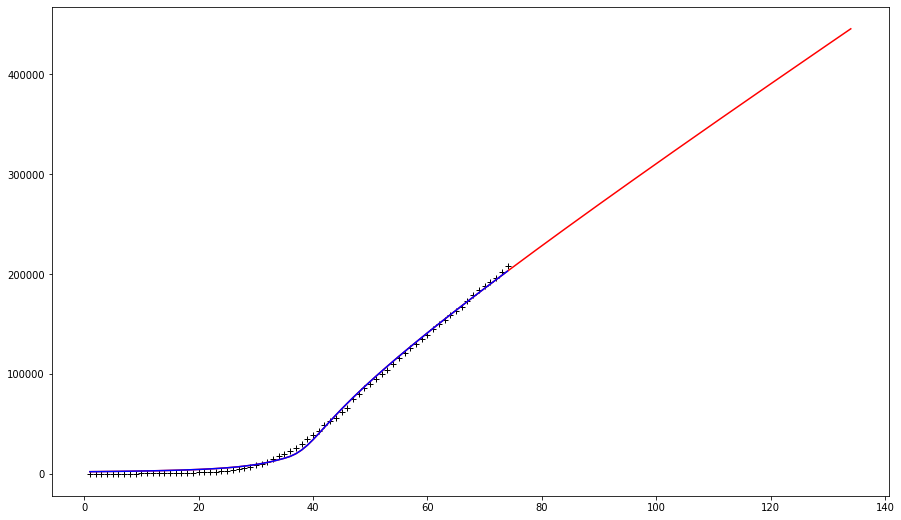

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [40]:
theCountry='United Kingdom'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedUKCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 53
    # variables        = 4
    chi-square         = 0.01433704
    reduced chi-square = 2.9259e-04
    Akaike info crit   = -427.405653
    Bayesian info crit = -419.524486
[[Variables]]
    amp:        0.23968710 +/- 0.02227903 (9.30%) (init = 1)
    scale:      5.87458220 +/- 0.30764627 (5.24%) (init = 1)
    loc:        20.3216697 +/- 0.63290678 (3.11%) (init = 70)
    decaybase:  0.95833042 +/- 0.01037035 (1.08%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.987
    C(loc, decaybase)   =  0.956
    C(amp, loc)         =  0.950
    C(amp, scale)       =  0.431
    C(scale, decaybase) =  0.300
    C(scale, loc)       =  0.212


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



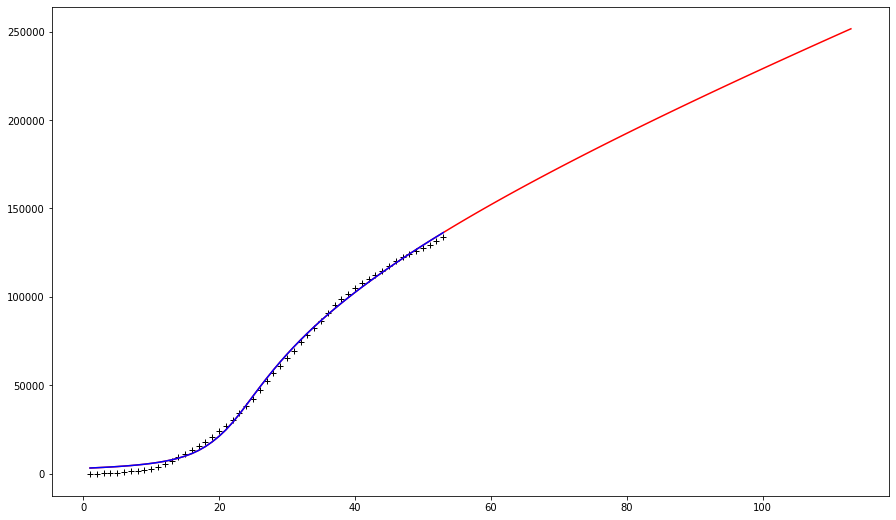

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [41]:
theCountry='Turkey'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedTurkeyCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6362
    # data points      = 77
    # variables        = 4
    chi-square         = 0.02413575
    reduced chi-square = 3.3063e-04
    Akaike info crit   = -613.225721
    Bayesian info crit = -603.850499
[[Variables]]
    amp:        0.31603084 +/- 0.01933216 (6.12%) (init = 1)
    scale:      9.01122784 +/- 0.36699672 (4.07%) (init = 1)
    loc:        31.4772324 +/- 0.70530733 (2.24%) (init = 70)
    decaybase:  0.99188952 +/- 0.00361263 (0.36%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.970
    C(amp, loc)         =  0.954
    C(loc, decaybase)   =  0.949
    C(amp, scale)       =  0.641
    C(scale, loc)       =  0.474
    C(scale, decaybase) =  0.453


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



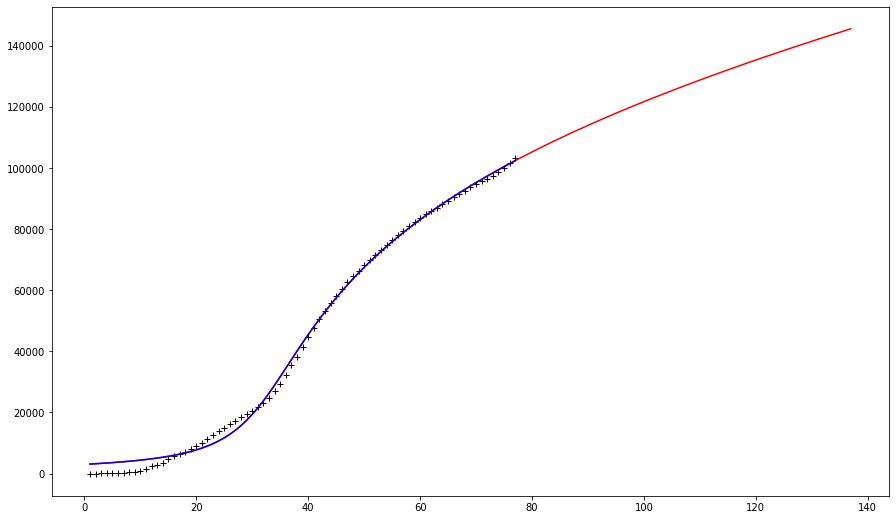

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [42]:
theCountry='Iran'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedIranCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 95
    # variables        = 4
    chi-square         = 0.02307890
    reduced chi-square = 2.5361e-04
    Akaike info crit   = -782.657765
    Bayesian info crit = -772.442257
[[Variables]]
    amp:        0.29309390 +/- 0.01125218 (3.84%) (init = 1)
    scale:      5.00040206 +/- 0.23480788 (4.70%) (init = 1)
    loc:        51.8056947 +/- 0.27296078 (0.53%) (init = 70)
    decaybase:  0.99586394 +/- 0.00248430 (0.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.937
    C(loc, decaybase)   =  0.867
    C(amp, loc)         =  0.841
    C(amp, scale)       =  0.806
    C(scale, decaybase) =  0.568
    C(scale, loc)       =  0.476


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



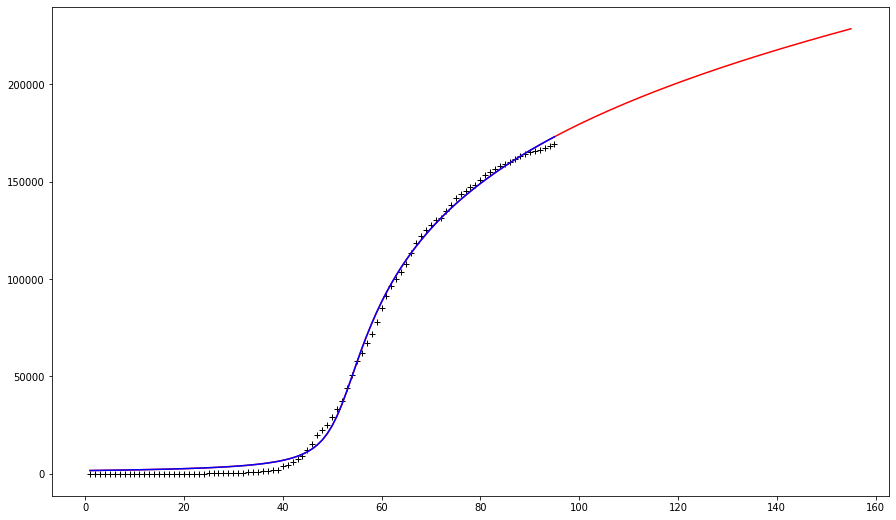

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [43]:
theCountry='Germany'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedCanadaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 90
    # variables        = 4
    chi-square         = 0.11301251
    reduced chi-square = 0.00131410
    Akaike info crit   = -593.205979
    Bayesian info crit = -583.206741
[[Variables]]
    amp:        0.39251492 +/- 0.03373139 (8.59%) (init = 1)
    scale:      6.97830718 +/- 0.51672581 (7.40%) (init = 1)
    loc:        53.5159150 +/- 0.84950318 (1.59%) (init = 70)
    decaybase:  1.00500000 +/- 2.5183e-05 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, loc)         =  0.932
    C(amp, decaybase)   = -0.930
    C(loc, decaybase)   = -0.908
    C(amp, scale)       =  0.686
    C(scale, loc)       =  0.501
    C(scale, decaybase) = -0.396


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



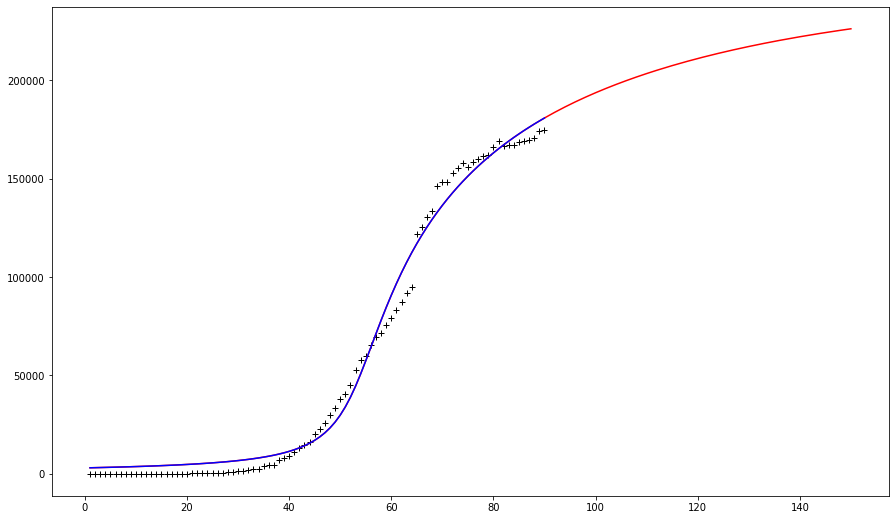

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [44]:
theCountry='France'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedCanadaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10003
    # data points      = 72
    # variables        = 4
    chi-square         = 2.02212306
    reduced chi-square = 0.02973710
    Akaike info crit   = -249.221306
    Bayesian info crit = -240.114642
##  Warning: uncertainties could not be estimated:
    decaybase:  at boundary
[[Variables]]
    amp:        1.20839418 (init = 1)
    scale:      26.1567140 (init = 1)
    loc:        59.0998500 (init = 70)
    decaybase:  1.00499323 (init = 1)


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



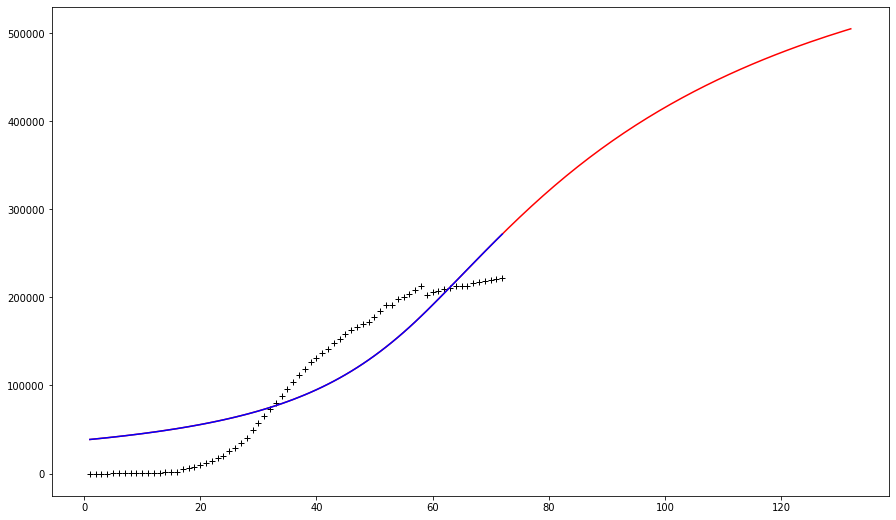

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [45]:
theCountry='Spain'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedCanadaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5230
    # data points      = 77
    # variables        = 4
    chi-square         = 0.01207030
    reduced chi-square = 1.6535e-04
    Akaike info crit   = -666.582562
    Bayesian info crit = -657.207340
[[Variables]]
    amp:        0.20940296 +/- 0.00952136 (4.55%) (init = 1)
    scale:      6.09309753 +/- 0.27085413 (4.45%) (init = 1)
    loc:        26.5579966 +/- 0.34182935 (1.29%) (init = 70)
    decaybase:  0.96760816 +/- 0.00371038 (0.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.980
    C(loc, decaybase)   =  0.888
    C(amp, loc)         =  0.862
    C(amp, scale)       =  0.700
    C(scale, decaybase) =  0.562
    C(scale, loc)       =  0.339


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



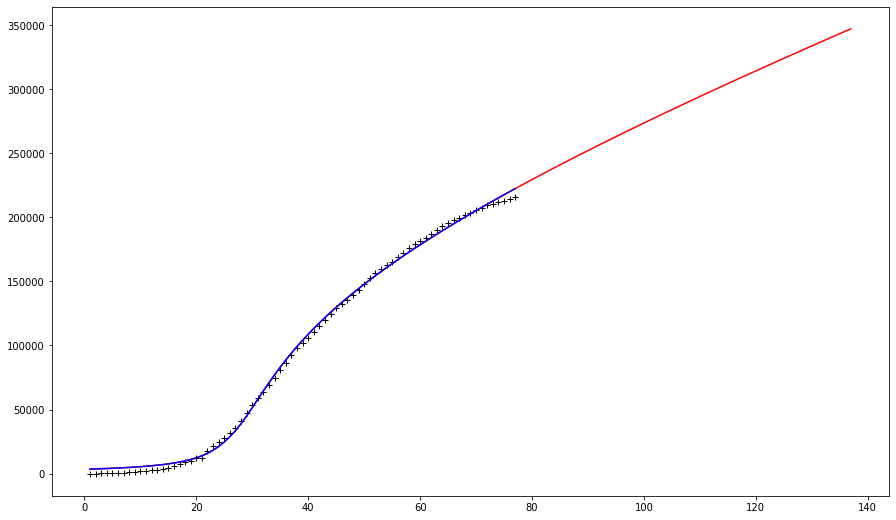

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [46]:
theCountry='Italy'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=10
theData=confirmed_series_21[confirmed_series_21[theCountry]>threshhold] 

data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

# output.iplot(asFigure=True,
#              mode='lines+markers',
#              size=6,secondary_y = 'Increase',
#              secondary_y_title='Increase',
#              xTitle='Date',
#              yTitle='Cases',
#              title=figfiletitle)

@interact
def plot_ProjectedCanadaCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)

In [47]:
def Cauchy_cumulative_hazard_fit(x,loc,scale,decaybase):
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    CHF=-np.log(0.5 - np.arctan(z)/np.pi)
    return CHF

# define objective function: returns the array to be minimized
def Cauchy_cumulative_hazard_residual(params, x, data):
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    loc = params['loc']
    scale = params['scale']
    decaybase=params['decaybase']
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    CHF=-np.log(0.5 - np.arctan(z)/np.pi)
    model = amp * CHF
    return model - data
# https://data.humdata.org/dataset/coronavirus-covid-19-cases-data-for-china-and-the-rest-of-the-world
# datafile="data/COVID19/WHO COVID Cases Data - covid-19 historical cases by country.csv"
# data00=pd.read_csv(datafile)

# data00=data00[['DateOfDataEntry','cum_conf']]
# data00['DateOfDataEntry']=pd.to_datetime(data00['DateOfDataEntry'])
# dataWorld=data00.groupby('DateOfDataEntry').sum()
dateData=pd.to_datetime(worldTot.index)
start_date=pd.to_datetime(worldTot.index[0])
end_date=pd.to_datetime(worldTot.index[-1])

data=worldTot['cases']

forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=100, min=0)
params.add('decaybase',value=1,min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard_fit(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
#output
output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')
# 

@interact
def plot_ProjectedWorldCOVID191():
    fig=output.iplot(asFigure=True,
             mode='lines+markers',
             size=3,secondary_y = 'Increase',
             secondary_y_title='Increase',
             xTitle='Date',
             yTitle='Cases',
             title='Projected COVID-19 Cases over the World',
             theme='solar',
             filename='COVID19-World',
             sharing='public')
    fig.show()
    url=py.iplot(fig, filename='COVID19-World1')
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 442
    # data points      = 107
    # variables        = 4
    chi-square         = 0.01183251
    reduced chi-square = 1.1488e-04
    Akaike info crit   = -966.741440
    Bayesian info crit = -956.050125
[[Variables]]
    amp:        0.11103521 +/- 0.00891519 (8.03%) (init = 1)
    scale:      16.3719700 +/- 1.82711583 (11.16%) (init = 1)
    loc:        61.0299980 +/- 0.65664180 (1.08%) (init = 100)
    decaybase:  0.86639174 +/- 0.01343089 (1.55%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(scale, loc)       = -0.944
    C(loc, decaybase)   =  0.922
    C(amp, loc)         =  0.922
    C(scale, decaybase) = -0.861
    C(amp, scale)       = -0.837


interactive(children=(Output(),), _dom_classes=('widget-interact',))